# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "abomination-vaults-bestiary.db",
    "age-of-ashes-bestiary.db",
    "agents-of-edgewatch-bestiary.db",
    "april-fools-bestiary.db",
    "blog-bestiary.db",
    "blood-lords-bestiary.db",
    "book-of-the-dead-bestiary.db",
    "crown-of-the-kobold-king-bestiary.db",
    "extinction-curse-bestiary.db",
    "fall-of-plaguestone.db",
    "fists-of-the-ruby-phoenix-bestiary.db",
    "gatewalkers-bestiary.db",
    "impossible-lands-bestiary.db",
    "kingmaker-bestiary.db",
    "malevolence-bestiary.db",
    "menace-under-otari-bestiary.db",
    "monsters-of-myth-bestiary.db",
    "mwangi-expanse-bestiary.db",
    "night-of-the-gray-death-bestiary.db",
    "npc-gallery.db",
    "one-shot-bestiary.db",
    "outlaws-of-alkenstar-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
    "pathfinder-bestiary.db",
    "pathfinder-dark-archive.db",
    "pfs-introductions-bestiary.db",
    "pfs-season-1-bestiary.db",
    "pfs-season-2-bestiary.db",
    "pfs-season-3-bestiary.db",
    "pfs-season-4-bestiary.db",
    "quest-for-the-frozen-flame-bestiary.db",
    "shadows-at-sundown-bestiary.db",
    "strength-of-thousands-bestiary.db",
    "the-slithering-bestiary.db",
    "travel-guide-bestiary.db",
    "troubles-in-otari-bestiary.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wis                     3690 non-null   float64
 1   level                   3690 non-null   int64  
 2   con                     3690 non-null   float64
 3   will                    3690 non-null   float64
 4   cha                     3690 non-null   float64
 5   int                     3690 non-null   float64
 6   fortitude               3690 non-null   float64
 7   str                     3690 non-null   float64
 8   land_speed              3690 non-null   float64
 9   perception              3690 non-null   float64
 10  hp                      3690 non-null   int32  
 11  reflex                  3690 non-null   float64
 12  dex                     3690 non-null   float64
 13  focus                   3690 non-null   int32  
 14  book                    3690 non-null   

In [3]:
df.head()

,wis,level,con,will,cha,int,fortitude,str,land_speed,perception,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,3.0,9,0.0,20.0,0.0,0.0,15.0,6.0,20.0,18.0,...,2,0,0,0,0,0,21,19.0,0,0.0
1,3.0,10,6.0,19.0,0.0,0.0,22.0,7.0,40.0,19.0,...,0,0,0,0,0,0,23,22.0,0,0.0
2,3.0,2,1.0,9.0,1.0,-2.0,7.0,4.0,30.0,7.0,...,0,0,0,0,0,0,9,6.5,8,6.5
3,3.0,8,3.0,15.0,1.0,0.0,17.0,3.0,30.0,16.0,...,0,0,0,0,0,0,20,18.0,20,9.5
4,4.0,9,0.0,18.0,2.0,2.0,14.0,-5.0,0.0,20.0,...,0,0,0,0,0,0,17,21.5,0,0.0


###### Level

In [4]:
y = df["level"]
y

0        9
1       10
2        2
3        8
4        9
        ..
4322     2
4324     3
4325     4
4326     2
4327     2
Name: level, Length: 3690, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,147
1,0,87
2,1,320
3,2,335
4,3,339
5,4,274
6,5,268
7,6,220
8,7,215
9,8,188


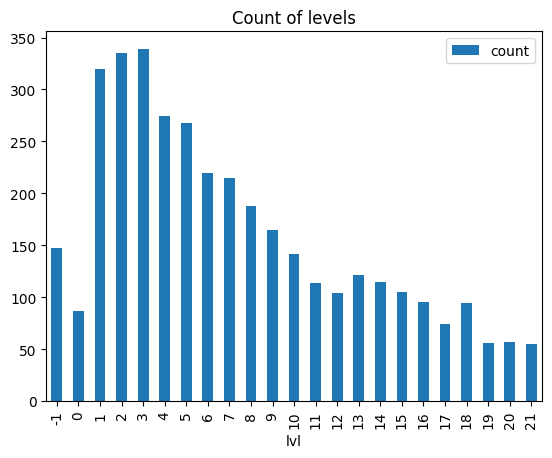

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 1626, number of used features: 50
[LightGBM] [Info] Start training from score 7.212177
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.356002	valid_0's l2: 0.355716


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.60
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.17
RMSE test: 0.60


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

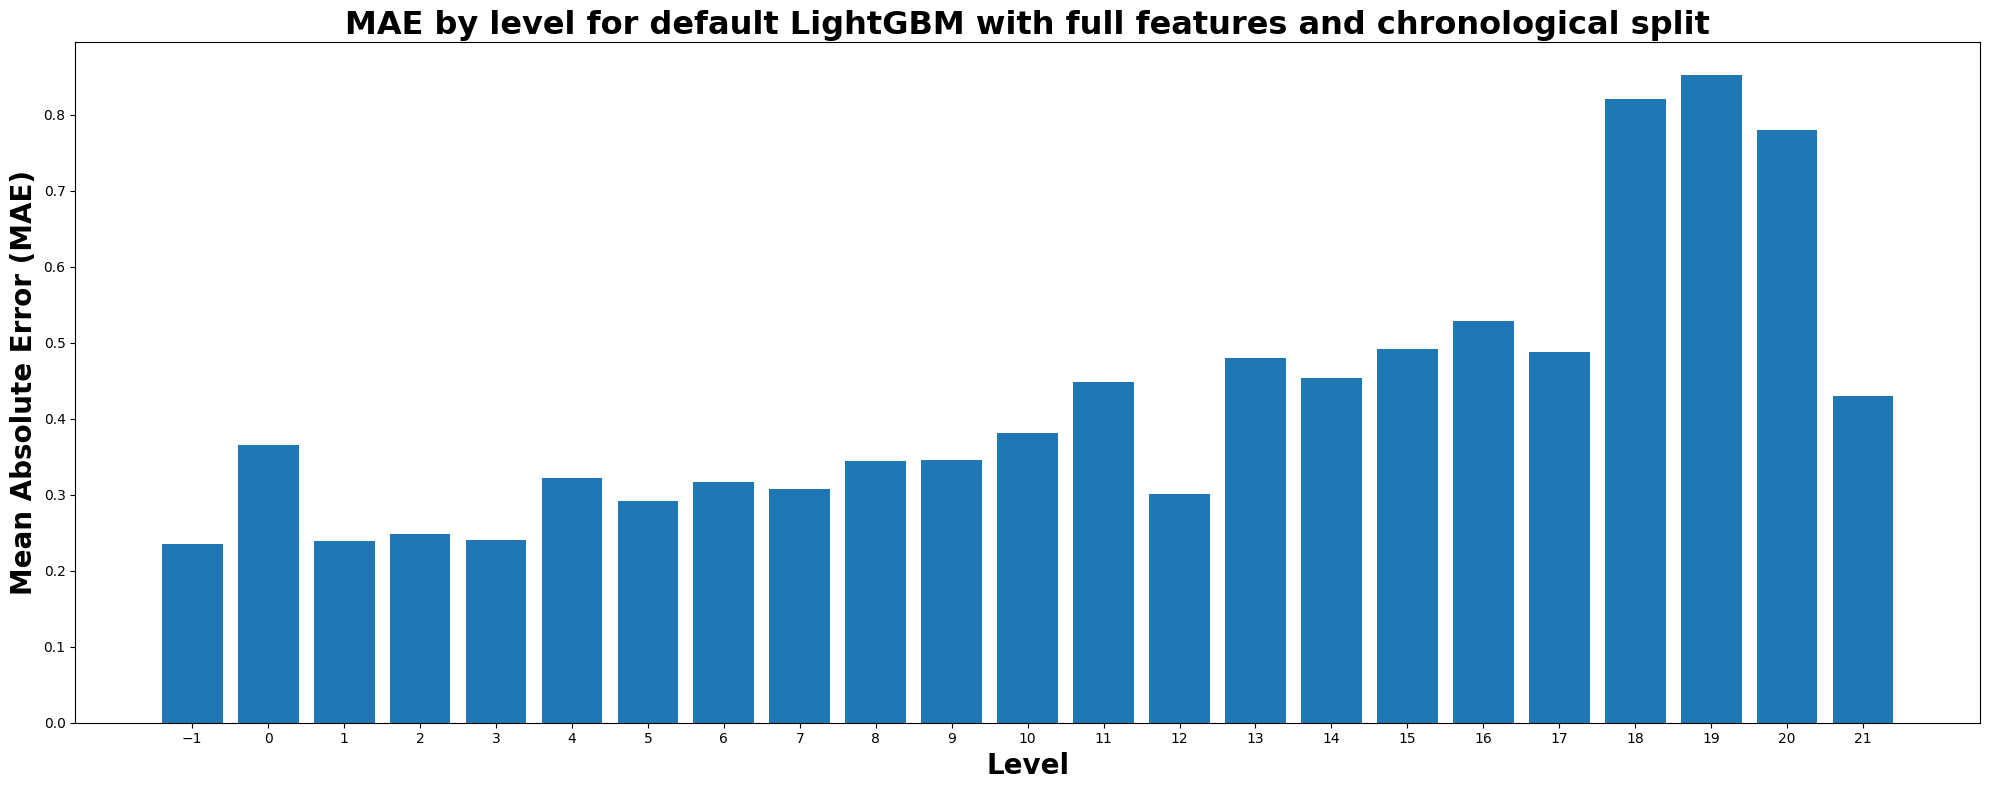

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [19]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.60

Round type: 0.5
RMSE: 0.62

Round type: 0.33
RMSE: 0.64

Round type: 0.45
RMSE: 0.62



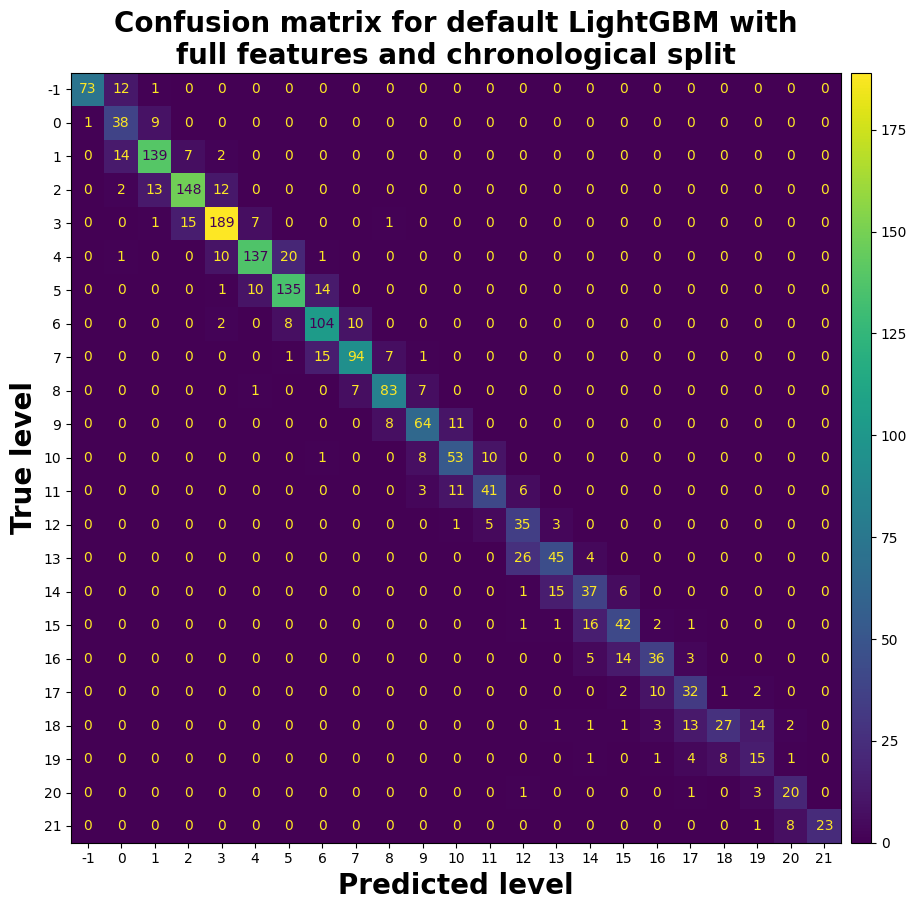

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nfull features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-28 15:21:54,469] A new study created in memory with name: no-name-2d30ab9c-9e0e-45fd-b3bd-9967cdab6ac8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.195291 + 0.129767
[200]	cv_agg's l2: 0.188927 + 0.124621


feature_fraction, val_score: 0.188783:  14%|#4        | 1/7 [00:02<00:14,  2.39s/it]

[300]	cv_agg's l2: 0.189133 + 0.121959
Early stopping, best iteration is:
[205]	cv_agg's l2: 0.188783 + 0.12436
[100]	cv_agg's l2: 0.174895 + 0.113979
[200]	cv_agg's l2: 0.170353 + 0.108591


feature_fraction, val_score: 0.170220:  29%|##8       | 2/7 [00:05<00:14,  2.88s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.185075 + 0.124482
[200]	cv_agg's l2: 0.179862 + 0.120352


feature_fraction, val_score: 0.170220:  43%|####2     | 3/7 [00:07<00:09,  2.39s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.185284 + 0.126276
[200]	cv_agg's l2: 0.179108 + 0.120128


feature_fraction, val_score: 0.170220:  57%|#####7    | 4/7 [00:11<00:09,  3.09s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.188835 + 0.110722
[200]	cv_agg's l2: 0.181719 + 0.105756


feature_fraction, val_score: 0.170220:  71%|#######1  | 5/7 [00:16<00:07,  3.66s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.182319 + 0.126958
[200]	cv_agg's l2: 0.177157 + 0.12236


feature_fraction, val_score: 0.170220:  86%|########5 | 6/7 [00:18<00:03,  3.11s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.187995 + 0.130667
[200]	cv_agg's l2: 0.183796 + 0.12623


feature_fraction, val_score: 0.170220: 100%|##########| 7/7 [00:20<00:00,  2.93s/it]


Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294


num_leaves, val_score: 0.170220:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876


num_leaves, val_score: 0.170220:   5%|5         | 1/20 [00:04<01:22,  4.36s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876


num_leaves, val_score: 0.170220:  10%|#         | 2/20 [00:08<01:17,  4.29s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876


num_leaves, val_score: 0.170220:  15%|#5        | 3/20 [00:11<01:02,  3.68s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.176346 + 0.11558
[200]	cv_agg's l2: 0.172232 + 0.110669


num_leaves, val_score: 0.170220:  20%|##        | 4/20 [00:14<00:53,  3.32s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.17022 + 0.109294
[100]	cv_agg's l2: 0.199686 + 0.11268
[200]	cv_agg's l2: 0.175873 + 0.0980688
[300]	cv_agg's l2: 0.168772 + 0.0951705
[400]	cv_agg's l2: 0.165585 + 0.0935629
[500]	cv_agg's l2: 0.16431 + 0.0935876
[600]	cv_agg's l2: 0.163983 + 0.0939916


num_leaves, val_score: 0.163628:  25%|##5       | 5/20 [00:23<01:19,  5.27s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.227665 + 0.118159
[200]	cv_agg's l2: 0.190233 + 0.102895
[300]	cv_agg's l2: 0.178087 + 0.0972438
[400]	cv_agg's l2: 0.173579 + 0.0959571
[500]	cv_agg's l2: 0.170844 + 0.0949608
[600]	cv_agg's l2: 0.170454 + 0.0947392


num_leaves, val_score: 0.163628:  30%|###       | 6/20 [00:28<01:14,  5.31s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  35%|###5      | 7/20 [00:58<02:55, 13.53s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  40%|####      | 8/20 [01:17<03:03, 15.25s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  45%|####5     | 9/20 [01:44<03:25, 18.71s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  50%|#####     | 10/20 [02:01<03:02, 18.27s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  55%|#####5    | 11/20 [02:33<03:21, 22.37s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181851 + 0.122149
[200]	cv_agg's l2: 0.178472 + 0.115969
[300]	cv_agg's l2: 0.178857 + 0.114774
[400]	cv_agg's l2: 0.179638 + 0.114073
[500]	cv_agg's l2: 0.1799 + 0.11378
[600]	cv_agg's l2: 0.180343 + 0.113507


num_leaves, val_score: 0.163628:  60%|######    | 12/20 [02:53<02:54, 21.81s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  65%|######5   | 13/20 [03:08<02:18, 19.84s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  70%|#######   | 14/20 [03:29<02:00, 20.10s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.25478 + 0.13643
[200]	cv_agg's l2: 0.212596 + 0.116469
[300]	cv_agg's l2: 0.196148 + 0.107262
[400]	cv_agg's l2: 0.186983 + 0.100261
[500]	cv_agg's l2: 0.181998 + 0.0958742
[600]	cv_agg's l2: 0.178786 + 0.0925867


num_leaves, val_score: 0.163628:  75%|#######5  | 15/20 [03:33<01:15, 15.16s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.174895 + 0.113979
[200]	cv_agg's l2: 0.170353 + 0.108591
[300]	cv_agg's l2: 0.170501 + 0.107724
[400]	cv_agg's l2: 0.171158 + 0.107303
[500]	cv_agg's l2: 0.171175 + 0.106849
[600]	cv_agg's l2: 0.171594 + 0.106554


num_leaves, val_score: 0.163628:  80%|########  | 16/20 [03:47<00:59, 14.86s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181075 + 0.121681
[200]	cv_agg's l2: 0.178423 + 0.116876
[300]	cv_agg's l2: 0.178028 + 0.114963
[400]	cv_agg's l2: 0.178436 + 0.114331
[500]	cv_agg's l2: 0.178852 + 0.11358
[600]	cv_agg's l2: 0.179232 + 0.113387


num_leaves, val_score: 0.163628:  85%|########5 | 17/20 [04:11<00:52, 17.51s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.381835 + 0.164619
[200]	cv_agg's l2: 0.321899 + 0.145548
[300]	cv_agg's l2: 0.303105 + 0.141549
[400]	cv_agg's l2: 0.292205 + 0.136744
[500]	cv_agg's l2: 0.283913 + 0.132689


num_leaves, val_score: 0.163628:  90%|######### | 18/20 [04:14<00:26, 13.15s/it]

[600]	cv_agg's l2: 0.277237 + 0.129514
Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.181646 + 0.121438
[200]	cv_agg's l2: 0.178754 + 0.116737
[300]	cv_agg's l2: 0.178132 + 0.114919
[400]	cv_agg's l2: 0.178591 + 0.114263
[500]	cv_agg's l2: 0.178956 + 0.113526
[600]	cv_agg's l2: 0.179291 + 0.113348


num_leaves, val_score: 0.163628:  95%|#########5| 19/20 [04:30<00:14, 14.04s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.180809 + 0.117192
[200]	cv_agg's l2: 0.178814 + 0.114635
[300]	cv_agg's l2: 0.179015 + 0.113058
[400]	cv_agg's l2: 0.179168 + 0.112138
[500]	cv_agg's l2: 0.180134 + 0.111821
[600]	cv_agg's l2: 0.180378 + 0.111572


num_leaves, val_score: 0.163628: 100%|##########| 20/20 [04:37<00:00, 13.88s/it]


Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653


bagging, val_score: 0.163628:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.196819 + 0.112193
[200]	cv_agg's l2: 0.174247 + 0.102607
[300]	cv_agg's l2: 0.167209 + 0.0997721
[400]	cv_agg's l2: 0.164698 + 0.0962303
[500]	cv_agg's l2: 0.164709 + 0.0954603
[600]	cv_agg's l2: 0.164627 + 0.0941876


bagging, val_score: 0.163628:  10%|#         | 1/10 [00:02<00:22,  2.53s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.201285 + 0.109991
[200]	cv_agg's l2: 0.176553 + 0.0981586
[300]	cv_agg's l2: 0.168999 + 0.0951018
[400]	cv_agg's l2: 0.167448 + 0.0915857
[500]	cv_agg's l2: 0.167331 + 0.0915766
[600]	cv_agg's l2: 0.16654 + 0.0907898


bagging, val_score: 0.163628:  20%|##        | 2/10 [00:05<00:22,  2.87s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.199241 + 0.114619
[200]	cv_agg's l2: 0.177636 + 0.102342
[300]	cv_agg's l2: 0.170987 + 0.100508
[400]	cv_agg's l2: 0.168192 + 0.0976822
[500]	cv_agg's l2: 0.168573 + 0.0973679
[600]	cv_agg's l2: 0.167903 + 0.0958163


bagging, val_score: 0.163628:  30%|###       | 3/10 [00:08<00:19,  2.72s/it]

Early stopping, best iteration is:
[551]	cv_agg's l2: 0.163628 + 0.0939653
[100]	cv_agg's l2: 0.195498 + 0.110595
[200]	cv_agg's l2: 0.173055 + 0.0979185
[300]	cv_agg's l2: 0.166184 + 0.0936316
[400]	cv_agg's l2: 0.163429 + 0.092991


bagging, val_score: 0.162648:  40%|####      | 4/10 [00:10<00:14,  2.46s/it]

[500]	cv_agg's l2: 0.16332 + 0.0910659
Early stopping, best iteration is:
[457]	cv_agg's l2: 0.162648 + 0.0921564
[100]	cv_agg's l2: 0.198838 + 0.107977
[200]	cv_agg's l2: 0.18074 + 0.102595
[300]	cv_agg's l2: 0.174017 + 0.0997977
[400]	cv_agg's l2: 0.171566 + 0.0978585
[500]	cv_agg's l2: 0.172093 + 0.0971512


bagging, val_score: 0.162648:  50%|#####     | 5/10 [00:13<00:12,  2.57s/it]

Early stopping, best iteration is:
[457]	cv_agg's l2: 0.162648 + 0.0921564
[100]	cv_agg's l2: 0.198499 + 0.118428
[200]	cv_agg's l2: 0.175169 + 0.109087
[300]	cv_agg's l2: 0.169029 + 0.102202
[400]	cv_agg's l2: 0.167231 + 0.0995025


bagging, val_score: 0.162648:  60%|######    | 6/10 [00:14<00:09,  2.31s/it]

[500]	cv_agg's l2: 0.166222 + 0.0980245
Early stopping, best iteration is:
[457]	cv_agg's l2: 0.162648 + 0.0921564
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169512 + 0.0895249
[300]	cv_agg's l2: 0.163327 + 0.0864111
[400]	cv_agg's l2: 0.160538 + 0.0852881
[500]	cv_agg's l2: 0.159091 + 0.0844762
[600]	cv_agg's l2: 0.158935 + 0.0841123


bagging, val_score: 0.157990:  70%|#######   | 7/10 [00:18<00:07,  2.60s/it]

Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752
[100]	cv_agg's l2: 0.198111 + 0.112166
[200]	cv_agg's l2: 0.176821 + 0.105619
[300]	cv_agg's l2: 0.169435 + 0.102989
[400]	cv_agg's l2: 0.168222 + 0.102603
[500]	cv_agg's l2: 0.166516 + 0.101466


bagging, val_score: 0.157990:  80%|########  | 8/10 [00:20<00:05,  2.65s/it][I 2023-11-28 15:27:13,405] Trial 34 finished with value: 0.16610121518005178 and parameters: {'bagging_fraction': 0.8989326809675204, 'bagging_freq': 4}. Best is trial 33 with value: 0.15798973016910753.


[600]	cv_agg's l2: 0.165947 + 0.1013
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752


bagging, val_score: 0.157990:  80%|########  | 8/10 [00:20<00:05,  2.65s/it]

[100]	cv_agg's l2: 0.218454 + 0.11687
[200]	cv_agg's l2: 0.200104 + 0.106108
[300]	cv_agg's l2: 0.191646 + 0.102846
[400]	cv_agg's l2: 0.187705 + 0.0965769
[500]	cv_agg's l2: 0.187009 + 0.0955673
[600]	cv_agg's l2: 0.186158 + 0.0922075
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752


bagging, val_score: 0.157990:  90%|######### | 9/10 [00:22<00:02,  2.43s/it]

[100]	cv_agg's l2: 0.195052 + 0.101701
[200]	cv_agg's l2: 0.174057 + 0.0930707
[300]	cv_agg's l2: 0.167436 + 0.0916054
[400]	cv_agg's l2: 0.163964 + 0.0919958
[500]	cv_agg's l2: 0.163981 + 0.0914534


bagging, val_score: 0.157990: 100%|##########| 10/10 [00:25<00:00,  2.55s/it]

[600]	cv_agg's l2: 0.163676 + 0.0897779
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752



feature_fraction_stage2, val_score: 0.157990:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.189117 + 0.114922
[200]	cv_agg's l2: 0.169975 + 0.105453
[300]	cv_agg's l2: 0.164187 + 0.100332
[400]	cv_agg's l2: 0.1626 + 0.0974057
[500]	cv_agg's l2: 0.161491 + 0.094806
[600]	cv_agg's l2: 0.161772 + 0.0931745
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752


feature_fraction_stage2, val_score: 0.157990:  17%|#6        | 1/6 [00:02<00:12,  2.60s/it]

[100]	cv_agg's l2: 0.186014 + 0.0991304
[200]	cv_agg's l2: 0.16684 + 0.0918247
[300]	cv_agg's l2: 0.163166 + 0.0868941
[400]	cv_agg's l2: 0.16129 + 0.085618
[500]	cv_agg's l2: 0.16058 + 0.0853677
[600]	cv_agg's l2: 0.160366 + 0.0846217
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752


feature_fraction_stage2, val_score: 0.157990:  33%|###3      | 2/6 [00:05<00:10,  2.70s/it]

[100]	cv_agg's l2: 0.187642 + 0.101642
[200]	cv_agg's l2: 0.167309 + 0.0911051
[300]	cv_agg's l2: 0.162404 + 0.0875635
[400]	cv_agg's l2: 0.160656 + 0.0874706
[500]	cv_agg's l2: 0.160411 + 0.0867819
[600]	cv_agg's l2: 0.159977 + 0.0867154


feature_fraction_stage2, val_score: 0.157990:  50%|#####     | 3/6 [00:07<00:07,  2.40s/it]

Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752
[100]	cv_agg's l2: 0.202979 + 0.113175
[200]	cv_agg's l2: 0.17923 + 0.101776
[300]	cv_agg's l2: 0.174262 + 0.098385
[400]	cv_agg's l2: 0.171373 + 0.0970801
[500]	cv_agg's l2: 0.169545 + 0.0965244


feature_fraction_stage2, val_score: 0.157990:  67%|######6   | 4/6 [00:09<00:04,  2.34s/it]

[600]	cv_agg's l2: 0.168825 + 0.0962512
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752
[100]	cv_agg's l2: 0.200504 + 0.114259
[200]	cv_agg's l2: 0.179018 + 0.105333
[300]	cv_agg's l2: 0.172789 + 0.101105
[400]	cv_agg's l2: 0.168942 + 0.0988251
[500]	cv_agg's l2: 0.167688 + 0.0983794
[600]	cv_agg's l2: 0.166887 + 0.097447
Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752


feature_fraction_stage2, val_score: 0.157990:  83%|########3 | 5/6 [00:12<00:02,  2.62s/it]

[100]	cv_agg's l2: 0.208541 + 0.122313
[200]	cv_agg's l2: 0.180556 + 0.105014
[300]	cv_agg's l2: 0.173978 + 0.0999566
[400]	cv_agg's l2: 0.1696 + 0.097213
[500]	cv_agg's l2: 0.167889 + 0.095127
[600]	cv_agg's l2: 0.167123 + 0.0940246


feature_fraction_stage2, val_score: 0.157990: 100%|##########| 6/6 [00:16<00:00,  2.70s/it]


Early stopping, best iteration is:
[560]	cv_agg's l2: 0.15799 + 0.0839752


regularization_factors, val_score: 0.157990:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158686 + 0.0823103


regularization_factors, val_score: 0.157624:   5%|5         | 1/20 [00:03<01:07,  3.54s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158686 + 0.0823103


regularization_factors, val_score: 0.157624:  10%|#         | 2/20 [00:07<01:09,  3.85s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851157
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158832 + 0.0832114
[600]	cv_agg's l2: 0.158307 + 0.0825607
[700]	cv_agg's l2: 0.158686 + 0.0823103


regularization_factors, val_score: 0.157624:  15%|#5        | 3/20 [00:12<01:14,  4.38s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158686 + 0.0823103
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832


regularization_factors, val_score: 0.157624:  20%|##        | 4/20 [00:16<01:05,  4.12s/it]

[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851157
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158832 + 0.0832114
[600]	cv_agg's l2: 0.158307 + 0.0825607


regularization_factors, val_score: 0.157624:  25%|##5       | 5/20 [00:20<01:00,  4.03s/it]

[700]	cv_agg's l2: 0.158686 + 0.0823103
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191164 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.089232
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158656 + 0.0823327


regularization_factors, val_score: 0.157624:  30%|###       | 6/20 [00:23<00:55,  3.93s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158656 + 0.0823327


regularization_factors, val_score: 0.157624:  35%|###5      | 7/20 [00:27<00:49,  3.78s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191164 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607


regularization_factors, val_score: 0.157624:  40%|####      | 8/20 [00:30<00:43,  3.65s/it]

[700]	cv_agg's l2: 0.158656 + 0.0823327
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892319
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607


regularization_factors, val_score: 0.157624:  45%|####5     | 9/20 [00:33<00:37,  3.38s/it]

[700]	cv_agg's l2: 0.158686 + 0.0823103
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191164 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.089232
[300]	cv_agg's l2: 0.162923 + 0.0851158
[400]	cv_agg's l2: 0.160126 + 0.0837966
[500]	cv_agg's l2: 0.158831 + 0.0832114
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158656 + 0.0823327


regularization_factors, val_score: 0.157624:  50%|#####     | 10/20 [00:37<00:35,  3.58s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191164 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.089232
[300]	cv_agg's l2: 0.162923 + 0.0851159
[400]	cv_agg's l2: 0.160126 + 0.0837967
[500]	cv_agg's l2: 0.158831 + 0.0832115
[600]	cv_agg's l2: 0.158306 + 0.0825607
[700]	cv_agg's l2: 0.158656 + 0.0823327


regularization_factors, val_score: 0.157624:  55%|#####5    | 11/20 [00:42<00:34,  3.84s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822832
[100]	cv_agg's l2: 0.191164 + 0.100492
[200]	cv_agg's l2: 0.169364 + 0.0892321
[300]	cv_agg's l2: 0.162923 + 0.085116
[400]	cv_agg's l2: 0.160126 + 0.0837967
[500]	cv_agg's l2: 0.158831 + 0.0832115
[600]	cv_agg's l2: 0.158306 + 0.0825608
[700]	cv_agg's l2: 0.158656 + 0.0823327


regularization_factors, val_score: 0.157624:  60%|######    | 12/20 [00:47<00:33,  4.23s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833
[100]	cv_agg's l2: 0.189421 + 0.100442
[200]	cv_agg's l2: 0.168784 + 0.0915166
[300]	cv_agg's l2: 0.162409 + 0.0870792
[400]	cv_agg's l2: 0.160047 + 0.0850623
[500]	cv_agg's l2: 0.15941 + 0.0848193
[600]	cv_agg's l2: 0.158887 + 0.0843398
[700]	cv_agg's l2: 0.159616 + 0.0839679


regularization_factors, val_score: 0.157624:  65%|######5   | 13/20 [00:51<00:30,  4.34s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833
[100]	cv_agg's l2: 0.191316 + 0.100793
[200]	cv_agg's l2: 0.170256 + 0.0910074
[300]	cv_agg's l2: 0.164255 + 0.0877457
[400]	cv_agg's l2: 0.161804 + 0.0870162
[500]	cv_agg's l2: 0.161021 + 0.0871105
[600]	cv_agg's l2: 0.160348 + 0.0862744
[700]	cv_agg's l2: 0.161268 + 0.0858372
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833


regularization_factors, val_score: 0.157624:  70%|#######   | 14/20 [00:55<00:24,  4.05s/it]

[100]	cv_agg's l2: 0.189485 + 0.0980732
[200]	cv_agg's l2: 0.170546 + 0.0909158
[300]	cv_agg's l2: 0.163314 + 0.087127
[400]	cv_agg's l2: 0.15996 + 0.0853513
[500]	cv_agg's l2: 0.159282 + 0.0854287
[600]	cv_agg's l2: 0.15939 + 0.0848115
[700]	cv_agg's l2: 0.160217 + 0.0850877


regularization_factors, val_score: 0.157624:  75%|#######5  | 15/20 [00:59<00:20,  4.09s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833
[100]	cv_agg's l2: 0.189316 + 0.0980668
[200]	cv_agg's l2: 0.168922 + 0.092909
[300]	cv_agg's l2: 0.162397 + 0.0879665
[400]	cv_agg's l2: 0.160447 + 0.0867034
[500]	cv_agg's l2: 0.158719 + 0.0855716
[600]	cv_agg's l2: 0.158645 + 0.0850178


regularization_factors, val_score: 0.157624:  80%|########  | 16/20 [01:02<00:15,  3.86s/it]

[700]	cv_agg's l2: 0.159254 + 0.0844915
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169512 + 0.0895249
[300]	cv_agg's l2: 0.163327 + 0.0864111
[400]	cv_agg's l2: 0.160538 + 0.0852881
[500]	cv_agg's l2: 0.159586 + 0.0854586
[600]	cv_agg's l2: 0.159081 + 0.0844021


regularization_factors, val_score: 0.157624:  85%|########5 | 17/20 [01:05<00:11,  3.67s/it]

[700]	cv_agg's l2: 0.159838 + 0.0836026
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833
[100]	cv_agg's l2: 0.191163 + 0.100492
[200]	cv_agg's l2: 0.169512 + 0.0895249
[300]	cv_agg's l2: 0.163327 + 0.0864111
[400]	cv_agg's l2: 0.160538 + 0.0852881
[500]	cv_agg's l2: 0.159586 + 0.0854586
[600]	cv_agg's l2: 0.159081 + 0.0844021
[700]	cv_agg's l2: 0.159838 + 0.0836026


regularization_factors, val_score: 0.157624:  90%|######### | 18/20 [01:09<00:07,  3.77s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157624 + 0.0822833
[100]	cv_agg's l2: 0.191164 + 0.100493
[200]	cv_agg's l2: 0.169364 + 0.0892325
[300]	cv_agg's l2: 0.162923 + 0.0851162
[400]	cv_agg's l2: 0.160125 + 0.0837969
[500]	cv_agg's l2: 0.15883 + 0.0832117
[600]	cv_agg's l2: 0.158305 + 0.0825609


regularization_factors, val_score: 0.157623:  95%|#########5| 19/20 [01:12<00:03,  3.53s/it]

[700]	cv_agg's l2: 0.158655 + 0.0823328
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834
[100]	cv_agg's l2: 0.191316 + 0.100793
[200]	cv_agg's l2: 0.170256 + 0.0910072
[300]	cv_agg's l2: 0.164255 + 0.0877456
[400]	cv_agg's l2: 0.161805 + 0.0870161
[500]	cv_agg's l2: 0.161021 + 0.0871104
[600]	cv_agg's l2: 0.16014 + 0.0861078


regularization_factors, val_score: 0.157623: 100%|##########| 20/20 [01:16<00:00,  3.80s/it]


[700]	cv_agg's l2: 0.161078 + 0.0850476
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834


min_data_in_leaf, val_score: 0.157623:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.231244 + 0.11211
[200]	cv_agg's l2: 0.20799 + 0.0989163
[300]	cv_agg's l2: 0.200761 + 0.0963156
[400]	cv_agg's l2: 0.196112 + 0.0935508
[500]	cv_agg's l2: 0.194644 + 0.0933135
[600]	cv_agg's l2: 0.193057 + 0.0933039
[700]	cv_agg's l2: 0.192959 + 0.0930591


min_data_in_leaf, val_score: 0.157623:  20%|##        | 1/5 [00:02<00:11,  2.88s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834
[100]	cv_agg's l2: 0.191682 + 0.10981
[200]	cv_agg's l2: 0.172039 + 0.0976426
[300]	cv_agg's l2: 0.168229 + 0.0957519
[400]	cv_agg's l2: 0.166478 + 0.0956253
[500]	cv_agg's l2: 0.166843 + 0.0958549
[600]	cv_agg's l2: 0.166135 + 0.0960226
[700]	cv_agg's l2: 0.164709 + 0.0949923


min_data_in_leaf, val_score: 0.157623:  40%|####      | 2/5 [00:06<00:10,  3.44s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834
[100]	cv_agg's l2: 0.187984 + 0.105369
[200]	cv_agg's l2: 0.16767 + 0.094388
[300]	cv_agg's l2: 0.16059 + 0.0905043
[400]	cv_agg's l2: 0.15865 + 0.0892123
[500]	cv_agg's l2: 0.158629 + 0.0881931
[600]	cv_agg's l2: 0.159011 + 0.0867113


min_data_in_leaf, val_score: 0.157623:  60%|######    | 3/5 [00:10<00:07,  3.60s/it]

[700]	cv_agg's l2: 0.159224 + 0.0865565
Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834
[100]	cv_agg's l2: 0.409415 + 0.187163
[200]	cv_agg's l2: 0.365547 + 0.17777
[300]	cv_agg's l2: 0.348402 + 0.174588
[400]	cv_agg's l2: 0.344701 + 0.174824
[500]	cv_agg's l2: 0.342783 + 0.178162
[600]	cv_agg's l2: 0.337514 + 0.173911
[700]	cv_agg's l2: 0.338525 + 0.17672


min_data_in_leaf, val_score: 0.157623:  80%|########  | 4/5 [00:15<00:03,  3.99s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834
[100]	cv_agg's l2: 0.193158 + 0.0997303
[200]	cv_agg's l2: 0.171929 + 0.0942199
[300]	cv_agg's l2: 0.166197 + 0.0919057
[400]	cv_agg's l2: 0.163164 + 0.0906973
[500]	cv_agg's l2: 0.162187 + 0.0907593
[600]	cv_agg's l2: 0.16152 + 0.0902352
[700]	cv_agg's l2: 0.162516 + 0.0892553


min_data_in_leaf, val_score: 0.157623: 100%|##########| 5/5 [00:18<00:00,  3.74s/it]

Early stopping, best iteration is:
[643]	cv_agg's l2: 0.157623 + 0.0822834


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15762305257951437
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.2082904811620408e-08
    lambda_l2: 0.0028956698507939817
    num_leaves: 7
    feature_fraction: 0.6
    bagging_fraction: 0.801627180510277
    bagging_freq: 2
    min_child_samples: 20


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.01
RMSE test: 0.56
MAE test: 0.36



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    rmse,
    mae,
]

###### MAE by level

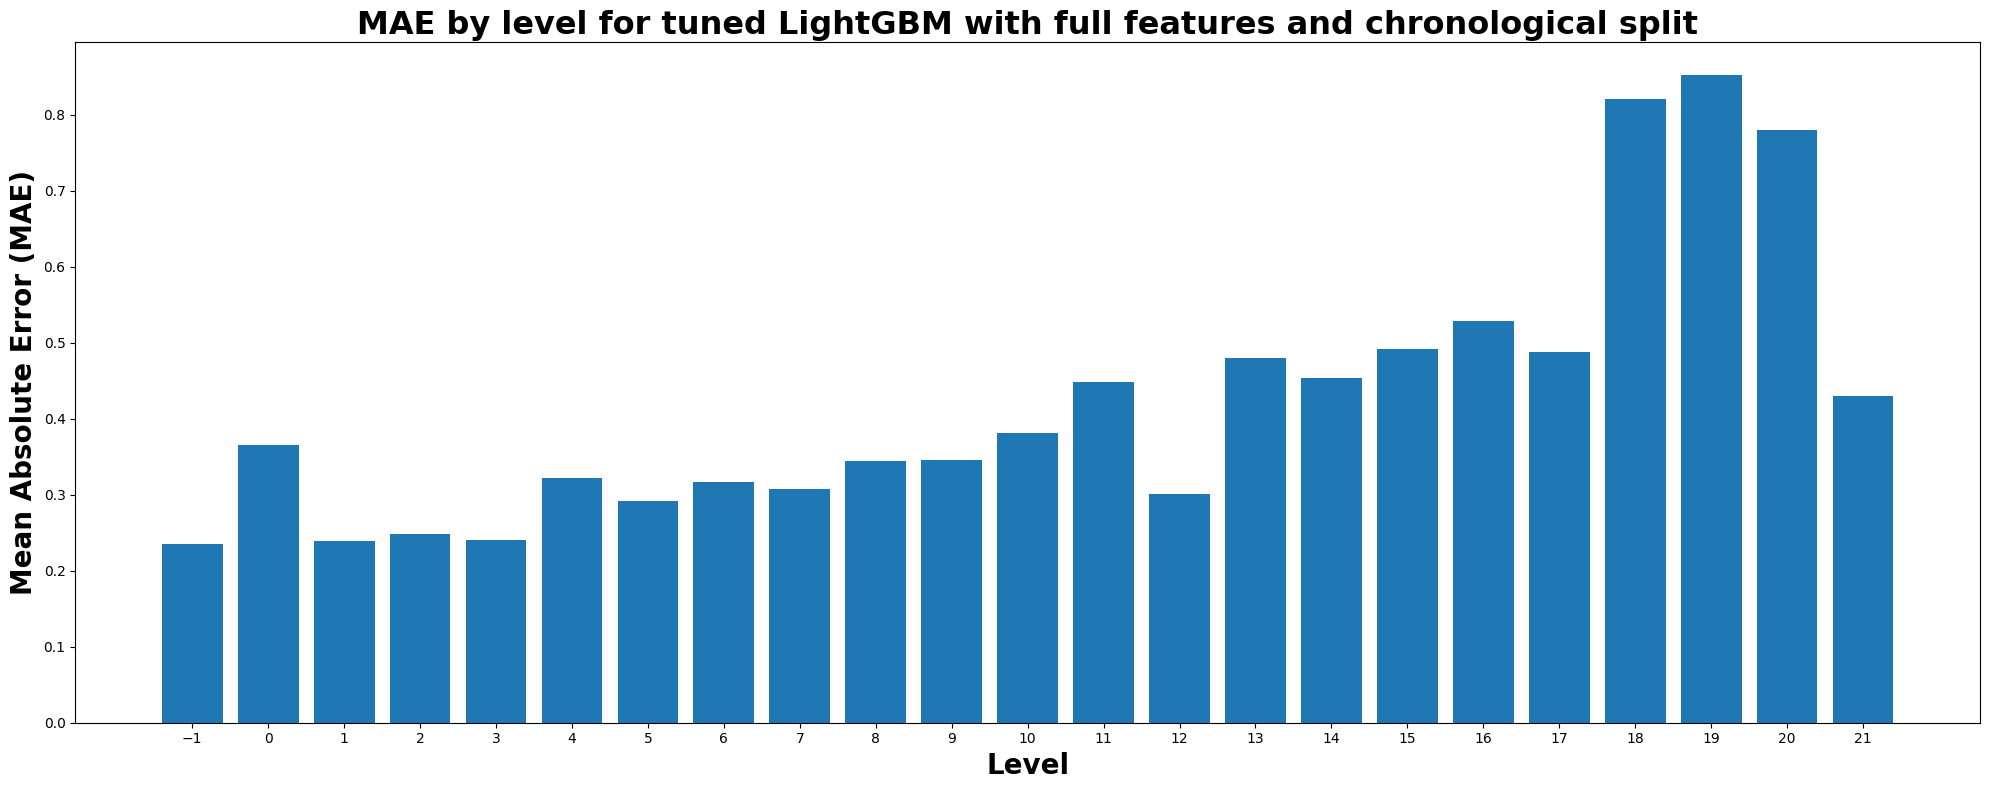

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.56

Round type: 0.5
RMSE: 0.61

Round type: 0.33
RMSE: 0.62

Round type: 0.45
RMSE: 0.60



In [30]:
predict[predict < -1] = -1
predict[predict > 21] = -1

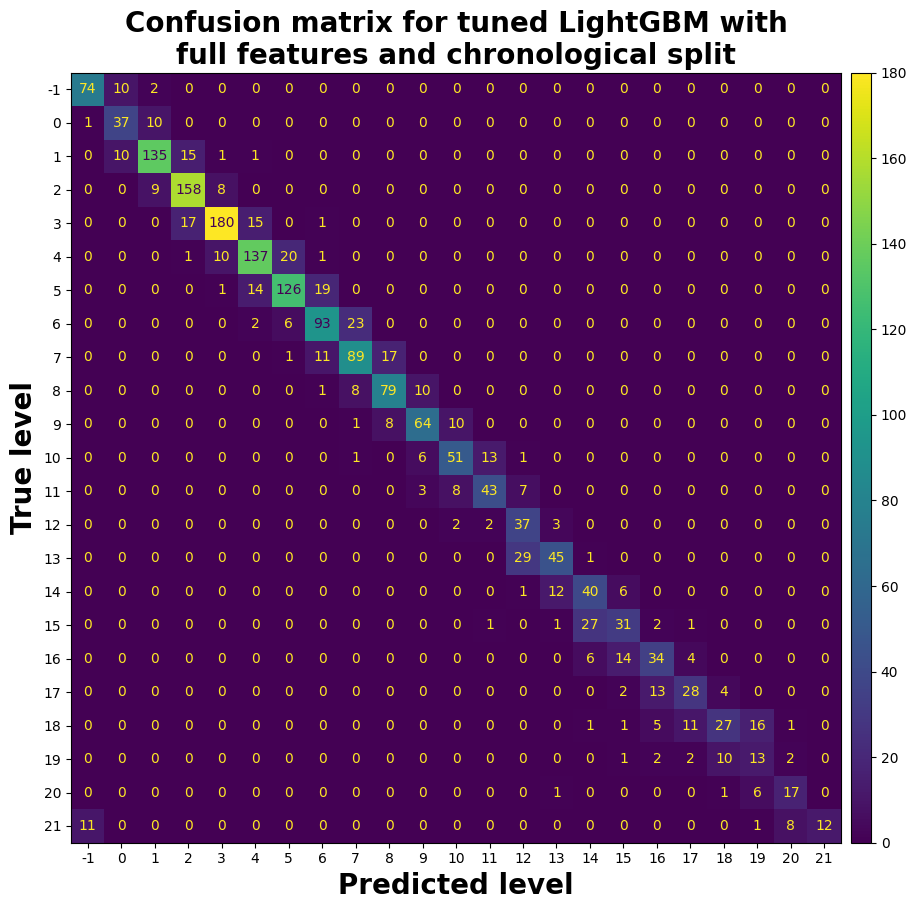

In [31]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nfull features and chronological split",
)

## Random split

In [32]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 50
[LightGBM] [Info] Start training from score 7.220455
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.258236	valid_0's l2: 0.144298


In [33]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.38
MAE: 0.26


In [35]:
results.loc[2] = ["random", "default", "full", rmse, mae]

###### MAE by level

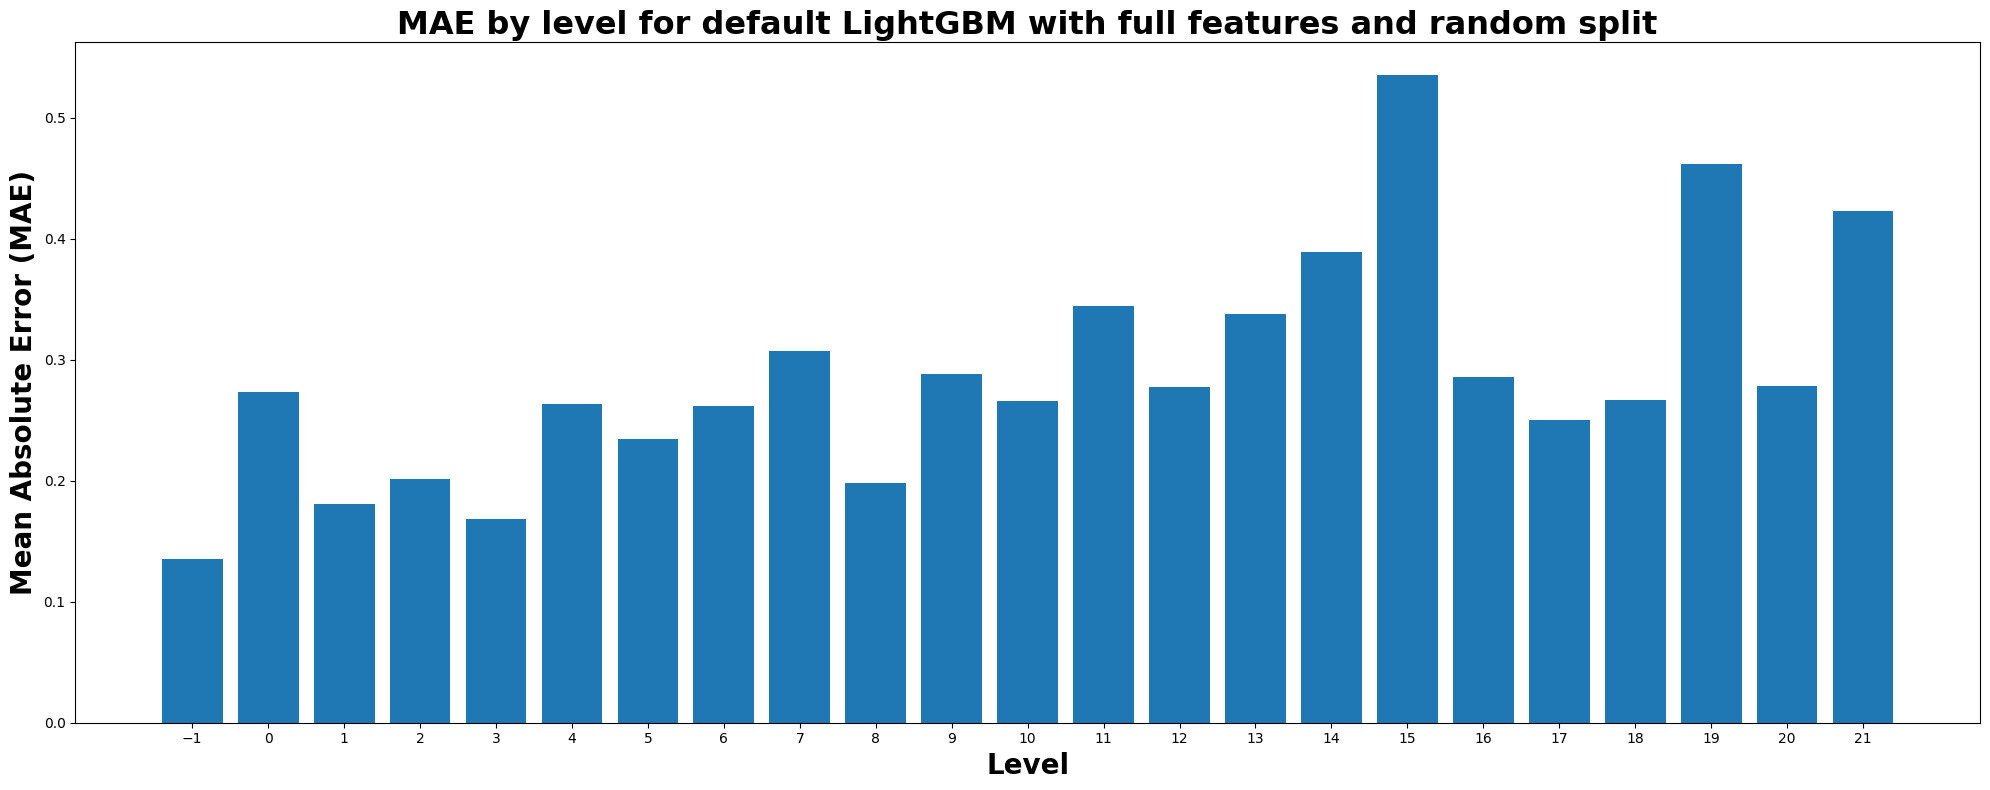

In [36]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [37]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.38

Round type: 0.5
RMSE: 0.41

Round type: 0.33
RMSE: 0.45

Round type: 0.45
RMSE: 0.42



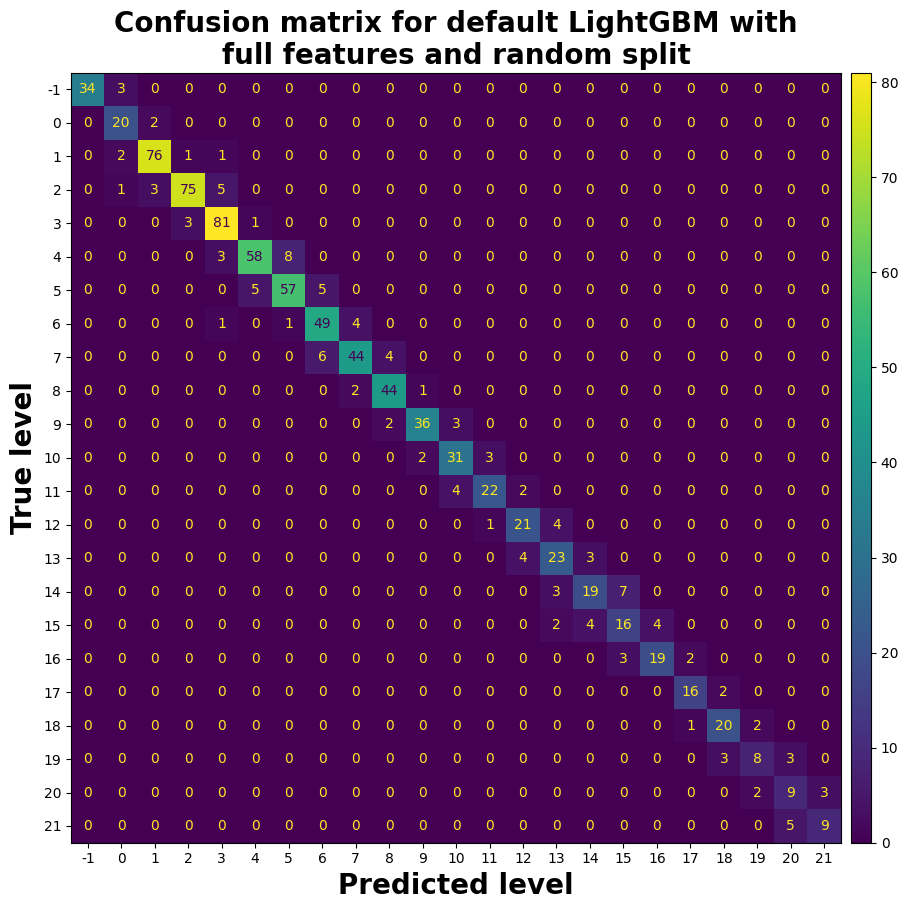

In [38]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nfull features and random split",
)

### Tuning

In [39]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-28 16:33:25,856] A new study created in memory with name: no-name-d8209c24-201a-492c-9b9a-0d8d4702c223
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.229818 + 0.0493082
[200]	cv_agg's l2: 0.225426 + 0.0471818
[300]	cv_agg's l2: 0.22487 + 0.0468127


feature_fraction, val_score: 0.224477:  14%|#4        | 1/7 [00:03<00:20,  3.41s/it]

Early stopping, best iteration is:
[262]	cv_agg's l2: 0.224477 + 0.0469409
[100]	cv_agg's l2: 0.228695 + 0.0473376
[200]	cv_agg's l2: 0.221219 + 0.0456344


feature_fraction, val_score: 0.221156:  29%|##8       | 2/7 [00:05<00:13,  2.64s/it]

[300]	cv_agg's l2: 0.222459 + 0.0455732
Early stopping, best iteration is:
[203]	cv_agg's l2: 0.221156 + 0.0456518
[100]	cv_agg's l2: 0.219305 + 0.0586631
[200]	cv_agg's l2: 0.216026 + 0.0564492


feature_fraction, val_score: 0.215670:  43%|####2     | 3/7 [00:08<00:10,  2.58s/it]

Early stopping, best iteration is:
[189]	cv_agg's l2: 0.21567 + 0.0564993
[100]	cv_agg's l2: 0.212867 + 0.0536335
[200]	cv_agg's l2: 0.20986 + 0.051902


feature_fraction, val_score: 0.209539:  57%|#####7    | 4/7 [00:10<00:07,  2.59s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.215884 + 0.0511811
[200]	cv_agg's l2: 0.213539 + 0.0488598


feature_fraction, val_score: 0.209539:  71%|#######1  | 5/7 [00:12<00:05,  2.50s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.219995 + 0.0594424
[200]	cv_agg's l2: 0.215535 + 0.0562978


feature_fraction, val_score: 0.209539:  86%|########5 | 6/7 [00:15<00:02,  2.68s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.219817 + 0.0567969
[200]	cv_agg's l2: 0.215776 + 0.0551379


feature_fraction, val_score: 0.209539: 100%|##########| 7/7 [00:19<00:00,  2.84s/it]


Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033


num_leaves, val_score: 0.209539:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:   5%|5         | 1/20 [00:04<01:21,  4.29s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  10%|#         | 2/20 [00:10<01:34,  5.26s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  15%|#5        | 3/20 [00:16<01:36,  5.70s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.22892 + 0.0498455
[200]	cv_agg's l2: 0.214225 + 0.0458117


num_leaves, val_score: 0.209539:  20%|##        | 4/20 [00:17<01:04,  4.01s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.258831 + 0.0552491
[200]	cv_agg's l2: 0.235212 + 0.0502746


num_leaves, val_score: 0.209539:  25%|##5       | 5/20 [00:19<00:45,  3.02s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  30%|###       | 6/20 [00:26<01:00,  4.33s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  35%|###5      | 7/20 [00:31<01:03,  4.86s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  40%|####      | 8/20 [00:38<01:04,  5.34s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.214983 + 0.0579414
[200]	cv_agg's l2: 0.216136 + 0.0570271


num_leaves, val_score: 0.209539:  45%|####5     | 9/20 [00:42<00:55,  5.04s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.219595 + 0.0611327
[200]	cv_agg's l2: 0.219306 + 0.0588067


num_leaves, val_score: 0.209539:  50%|#####     | 10/20 [00:47<00:48,  4.85s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  55%|#####5    | 11/20 [00:53<00:46,  5.19s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.214983 + 0.0579414
[200]	cv_agg's l2: 0.216136 + 0.0570271


num_leaves, val_score: 0.209539:  60%|######    | 12/20 [00:57<00:39,  4.96s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  65%|######5   | 13/20 [01:03<00:35,  5.12s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  70%|#######   | 14/20 [01:11<00:37,  6.18s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.214343 + 0.0550489
[200]	cv_agg's l2: 0.212844 + 0.053254


num_leaves, val_score: 0.209539:  75%|#######5  | 15/20 [01:14<00:26,  5.24s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.213128 + 0.0504494
[200]	cv_agg's l2: 0.211725 + 0.0492508


num_leaves, val_score: 0.209539:  80%|########  | 16/20 [01:18<00:19,  4.80s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.215164 + 0.0527965
[200]	cv_agg's l2: 0.21327 + 0.0510928


num_leaves, val_score: 0.209539:  85%|########5 | 17/20 [01:21<00:12,  4.25s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.21516 + 0.0571418
[200]	cv_agg's l2: 0.215766 + 0.0565351


num_leaves, val_score: 0.209539:  90%|######### | 18/20 [01:26<00:09,  4.53s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.214681 + 0.0535069
[200]	cv_agg's l2: 0.212673 + 0.0508782


num_leaves, val_score: 0.209539:  95%|#########5| 19/20 [01:32<00:04,  4.90s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.217562 + 0.0542999
[200]	cv_agg's l2: 0.214339 + 0.0514266


num_leaves, val_score: 0.209539: 100%|##########| 20/20 [01:36<00:00,  4.84s/it]


Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033


bagging, val_score: 0.209539:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.216407 + 0.0527997
[200]	cv_agg's l2: 0.214145 + 0.0502086


bagging, val_score: 0.209539:  10%|#         | 1/10 [00:04<00:43,  4.78s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.219801 + 0.0480513
[200]	cv_agg's l2: 0.214091 + 0.0452362


bagging, val_score: 0.209539:  20%|##        | 2/10 [00:10<00:43,  5.50s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.215166 + 0.053499
[200]	cv_agg's l2: 0.212873 + 0.0531903


bagging, val_score: 0.209539:  30%|###       | 3/10 [00:18<00:44,  6.41s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.225471 + 0.0579379
[200]	cv_agg's l2: 0.220295 + 0.0552279


bagging, val_score: 0.209539:  40%|####      | 4/10 [00:26<00:41,  6.95s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.216531 + 0.0565944
[200]	cv_agg's l2: 0.212851 + 0.0542913


bagging, val_score: 0.209539:  50%|#####     | 5/10 [00:30<00:31,  6.21s/it]

Early stopping, best iteration is:
[182]	cv_agg's l2: 0.209539 + 0.0517033
[100]	cv_agg's l2: 0.212448 + 0.0542036
[200]	cv_agg's l2: 0.210183 + 0.0512836
[300]	cv_agg's l2: 0.210615 + 0.0507269


bagging, val_score: 0.209428:  60%|######    | 6/10 [00:42<00:31,  7.99s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.219931 + 0.0531515
[200]	cv_agg's l2: 0.217109 + 0.0496342
[300]	cv_agg's l2: 0.21757 + 0.0490842


bagging, val_score: 0.209428:  70%|#######   | 7/10 [00:45<00:19,  6.51s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.218018 + 0.0560081
[200]	cv_agg's l2: 0.213389 + 0.0525307
[300]	cv_agg's l2: 0.214496 + 0.0518598


bagging, val_score: 0.209428:  80%|########  | 8/10 [00:48<00:10,  5.39s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.219615 + 0.0555379
[200]	cv_agg's l2: 0.216259 + 0.0520424
[300]	cv_agg's l2: 0.216796 + 0.0502313


bagging, val_score: 0.209428:  90%|######### | 9/10 [00:53<00:05,  5.02s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.218776 + 0.0557034
[200]	cv_agg's l2: 0.213748 + 0.0523368
[300]	cv_agg's l2: 0.213706 + 0.051786


bagging, val_score: 0.209428: 100%|##########| 10/10 [00:56<00:00,  5.64s/it]


Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284


feature_fraction_stage2, val_score: 0.209428:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.214712 + 0.0561602
[200]	cv_agg's l2: 0.212188 + 0.0517594
[300]	cv_agg's l2: 0.213253 + 0.051344


feature_fraction_stage2, val_score: 0.209428:  17%|#6        | 1/6 [00:04<00:21,  4.37s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.221105 + 0.0554236
[200]	cv_agg's l2: 0.21893 + 0.0522022
[300]	cv_agg's l2: 0.219582 + 0.0519724


feature_fraction_stage2, val_score: 0.209428:  33%|###3      | 2/6 [00:07<00:14,  3.73s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.221906 + 0.0566206
[200]	cv_agg's l2: 0.215842 + 0.0529576
[300]	cv_agg's l2: 0.216685 + 0.0516336


feature_fraction_stage2, val_score: 0.209428:  50%|#####     | 3/6 [00:12<00:12,  4.14s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.21471 + 0.056289
[200]	cv_agg's l2: 0.212262 + 0.0543608
[300]	cv_agg's l2: 0.213485 + 0.0528855


feature_fraction_stage2, val_score: 0.209428:  67%|######6   | 4/6 [00:15<00:07,  3.87s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.221633 + 0.0552335
[200]	cv_agg's l2: 0.216811 + 0.0508103
[300]	cv_agg's l2: 0.217666 + 0.0497577


feature_fraction_stage2, val_score: 0.209428:  83%|########3 | 5/6 [00:18<00:03,  3.53s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.209428 + 0.0507284
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


feature_fraction_stage2, val_score: 0.209150: 100%|##########| 6/6 [00:20<00:00,  3.47s/it]


Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762


regularization_factors, val_score: 0.209150:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:   5%|5         | 1/20 [00:02<00:55,  2.91s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  10%|#         | 2/20 [00:05<00:46,  2.60s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  15%|#5        | 3/20 [00:07<00:42,  2.48s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  20%|##        | 4/20 [00:09<00:38,  2.40s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  25%|##5       | 5/20 [00:12<00:34,  2.30s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  30%|###       | 6/20 [00:14<00:33,  2.43s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  35%|###5      | 7/20 [00:16<00:30,  2.35s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  40%|####      | 8/20 [00:19<00:27,  2.31s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  45%|####5     | 9/20 [00:21<00:25,  2.31s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  50%|#####     | 10/20 [00:23<00:23,  2.37s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  55%|#####5    | 11/20 [00:26<00:22,  2.50s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.209150:  60%|######    | 12/20 [00:29<00:21,  2.67s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.213041 + 0.0526197
[200]	cv_agg's l2: 0.210936 + 0.0515353


regularization_factors, val_score: 0.209150:  65%|######5   | 13/20 [00:32<00:18,  2.62s/it]

Early stopping, best iteration is:
[165]	cv_agg's l2: 0.20915 + 0.0516762
[100]	cv_agg's l2: 0.212785 + 0.0520624
[200]	cv_agg's l2: 0.208722 + 0.0502427


regularization_factors, val_score: 0.208425:  65%|######5   | 13/20 [00:35<00:18,  2.62s/it]

[300]	cv_agg's l2: 0.209232 + 0.0486606
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038


regularization_factors, val_score: 0.208425:  70%|#######   | 14/20 [00:35<00:17,  2.89s/it]

[100]	cv_agg's l2: 0.214889 + 0.0531876
[200]	cv_agg's l2: 0.212548 + 0.0514649


regularization_factors, val_score: 0.208425:  75%|#######5  | 15/20 [00:38<00:14,  2.92s/it]

[300]	cv_agg's l2: 0.214239 + 0.0492656
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038
[100]	cv_agg's l2: 0.213041 + 0.0526197
[200]	cv_agg's l2: 0.2108 + 0.0513844


regularization_factors, val_score: 0.208425:  80%|########  | 16/20 [00:42<00:12,  3.11s/it]

[300]	cv_agg's l2: 0.212775 + 0.0502484
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038
[100]	cv_agg's l2: 0.228185 + 0.0585121
[200]	cv_agg's l2: 0.216763 + 0.0526113


regularization_factors, val_score: 0.208425:  85%|########5 | 17/20 [00:45<00:09,  3.07s/it]

[300]	cv_agg's l2: 0.214513 + 0.0505338
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038
[100]	cv_agg's l2: 0.213041 + 0.0526197
[200]	cv_agg's l2: 0.210936 + 0.0515353


regularization_factors, val_score: 0.208425:  90%|######### | 18/20 [00:48<00:06,  3.08s/it]

[300]	cv_agg's l2: 0.212356 + 0.0498023
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038
[100]	cv_agg's l2: 0.212751 + 0.0528289
[200]	cv_agg's l2: 0.210824 + 0.0516219


regularization_factors, val_score: 0.208425:  95%|#########5| 19/20 [00:51<00:02,  2.99s/it]

[300]	cv_agg's l2: 0.212443 + 0.0497332
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038
[100]	cv_agg's l2: 0.255879 + 0.061198
[200]	cv_agg's l2: 0.239774 + 0.0564633


regularization_factors, val_score: 0.208425: 100%|##########| 20/20 [00:53<00:00,  2.66s/it]


[300]	cv_agg's l2: 0.235209 + 0.0540553
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038


min_data_in_leaf, val_score: 0.208425:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.321382 + 0.0489814
[200]	cv_agg's l2: 0.292226 + 0.042669


min_data_in_leaf, val_score: 0.208425:  20%|##        | 1/5 [00:01<00:05,  1.42s/it]

[300]	cv_agg's l2: 0.28046 + 0.0414412
Early stopping, best iteration is:
[212]	cv_agg's l2: 0.208425 + 0.050038
[100]	cv_agg's l2: 0.208474 + 0.0506828
[200]	cv_agg's l2: 0.207359 + 0.0483435
Early stopping, best iteration is:
[124]	cv_agg's l2: 0.20609 + 0.0480857


min_data_in_leaf, val_score: 0.206090:  40%|####      | 2/5 [00:03<00:05,  1.78s/it]

[100]	cv_agg's l2: 0.245742 + 0.0635556


min_data_in_leaf, val_score: 0.206090:  60%|######    | 3/5 [00:05<00:03,  1.75s/it][I 2023-11-28 16:37:38,060] Trial 65 finished with value: 0.23860930799984875 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.2060902046954017.


[200]	cv_agg's l2: 0.229151 + 0.0581768
Early stopping, best iteration is:
[124]	cv_agg's l2: 0.20609 + 0.0480857


min_data_in_leaf, val_score: 0.206090:  60%|######    | 3/5 [00:05<00:03,  1.75s/it]

[100]	cv_agg's l2: 0.208238 + 0.0456287
[200]	cv_agg's l2: 0.205355 + 0.0432794
[300]	cv_agg's l2: 0.205201 + 0.0420666


min_data_in_leaf, val_score: 0.204709:  80%|########  | 4/5 [00:08<00:02,  2.31s/it]

Early stopping, best iteration is:
[231]	cv_agg's l2: 0.204709 + 0.042906
[100]	cv_agg's l2: 0.222744 + 0.0604761
[200]	cv_agg's l2: 0.218498 + 0.0553605
[300]	cv_agg's l2: 0.219206 + 0.0544681


min_data_in_leaf, val_score: 0.204709: 100%|##########| 5/5 [00:11<00:00,  2.26s/it]

Early stopping, best iteration is:
[231]	cv_agg's l2: 0.204709 + 0.042906


In [40]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.20470896434490773
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0002459030576128089
    lambda_l2: 9.203975603330533e-05
    num_leaves: 31
    feature_fraction: 0.7799999999999999
    bagging_fraction: 0.6524723181765358
    bagging_freq: 3
    min_child_samples: 5


In [41]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [42]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.02
RMSE test: 0.36
MAE test: 0.24



In [43]:
results.loc[3] = ["random", "Optuna", "full", rmse, mae]

###### MAE by level

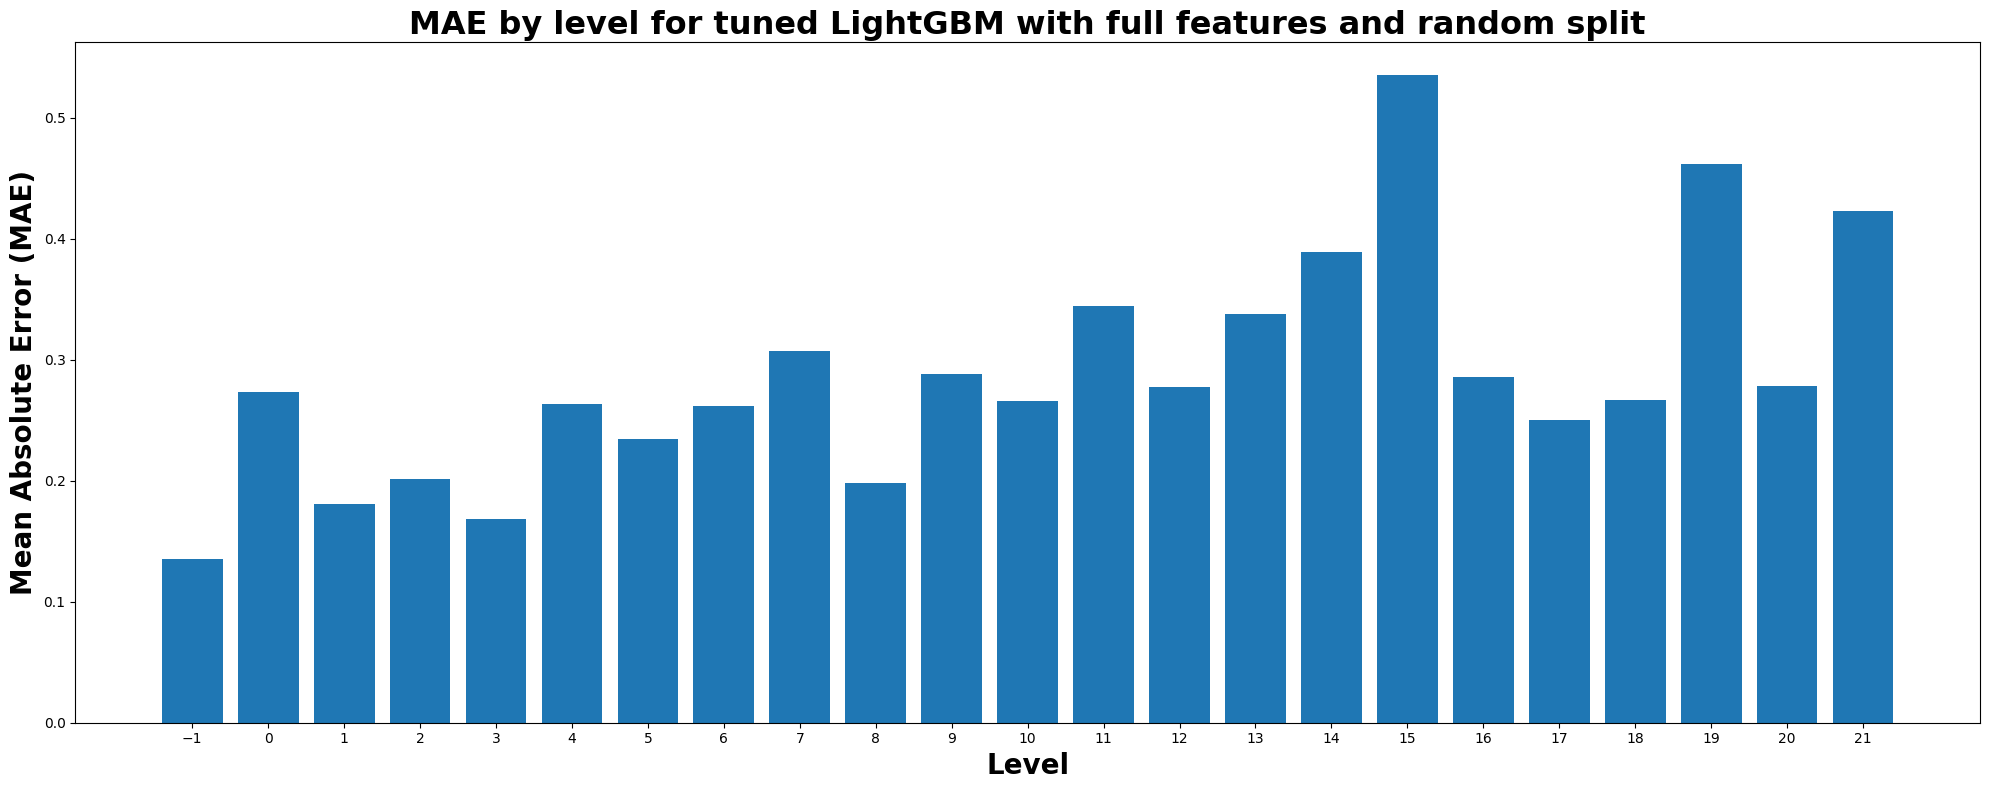

In [44]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
)

In [45]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.20

Round type: 0.5
RMSE: 0.22

Round type: 0.33
RMSE: 0.23

Round type: 0.45
RMSE: 0.21



In [47]:
predict[predict < -1] = -1
predict[predict > 21] = 21

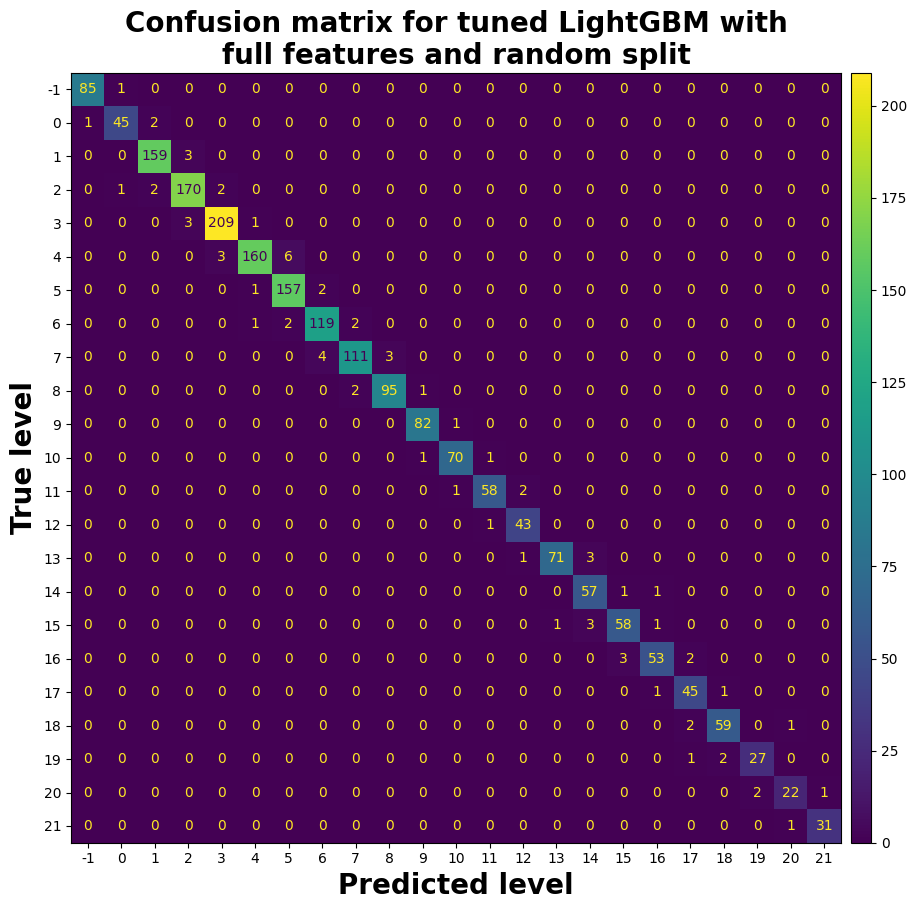

In [48]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nfull features and random split",
)

## Summary

In [49]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,full,0.596419,0.356002
1,chronological,Optuna,full,0.560526,0.358895
2,random,default,full,0.379865,0.258236
3,random,Optuna,full,0.358594,0.235527


In [50]:
from training.results import plot_summary

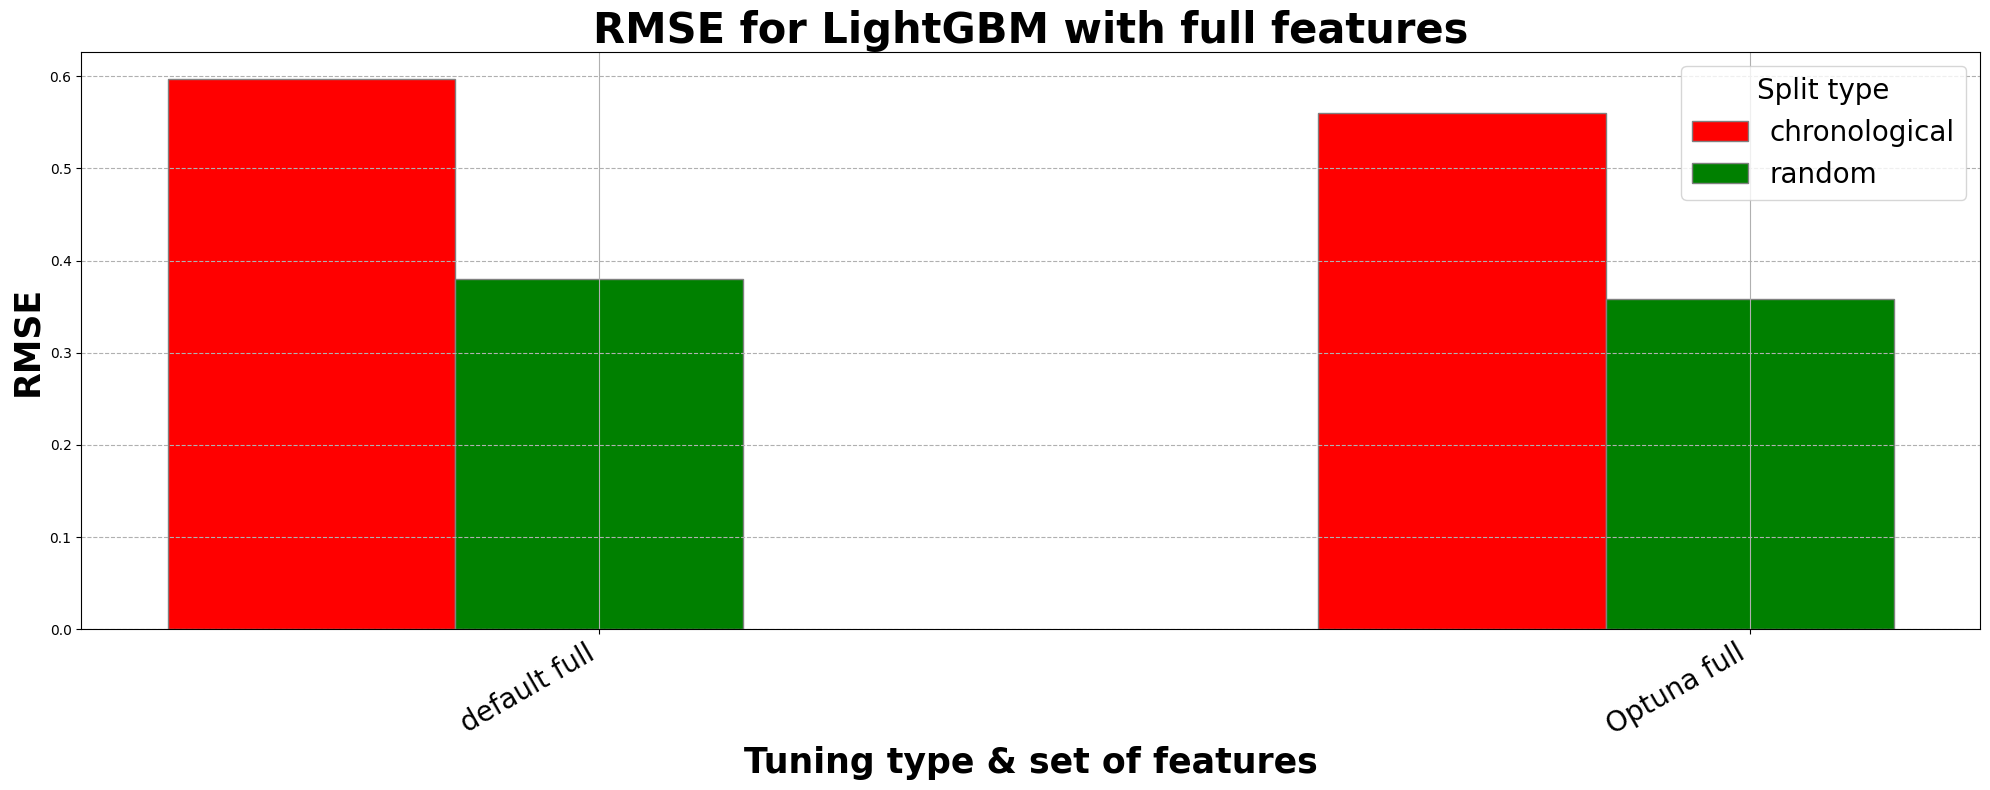

In [51]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

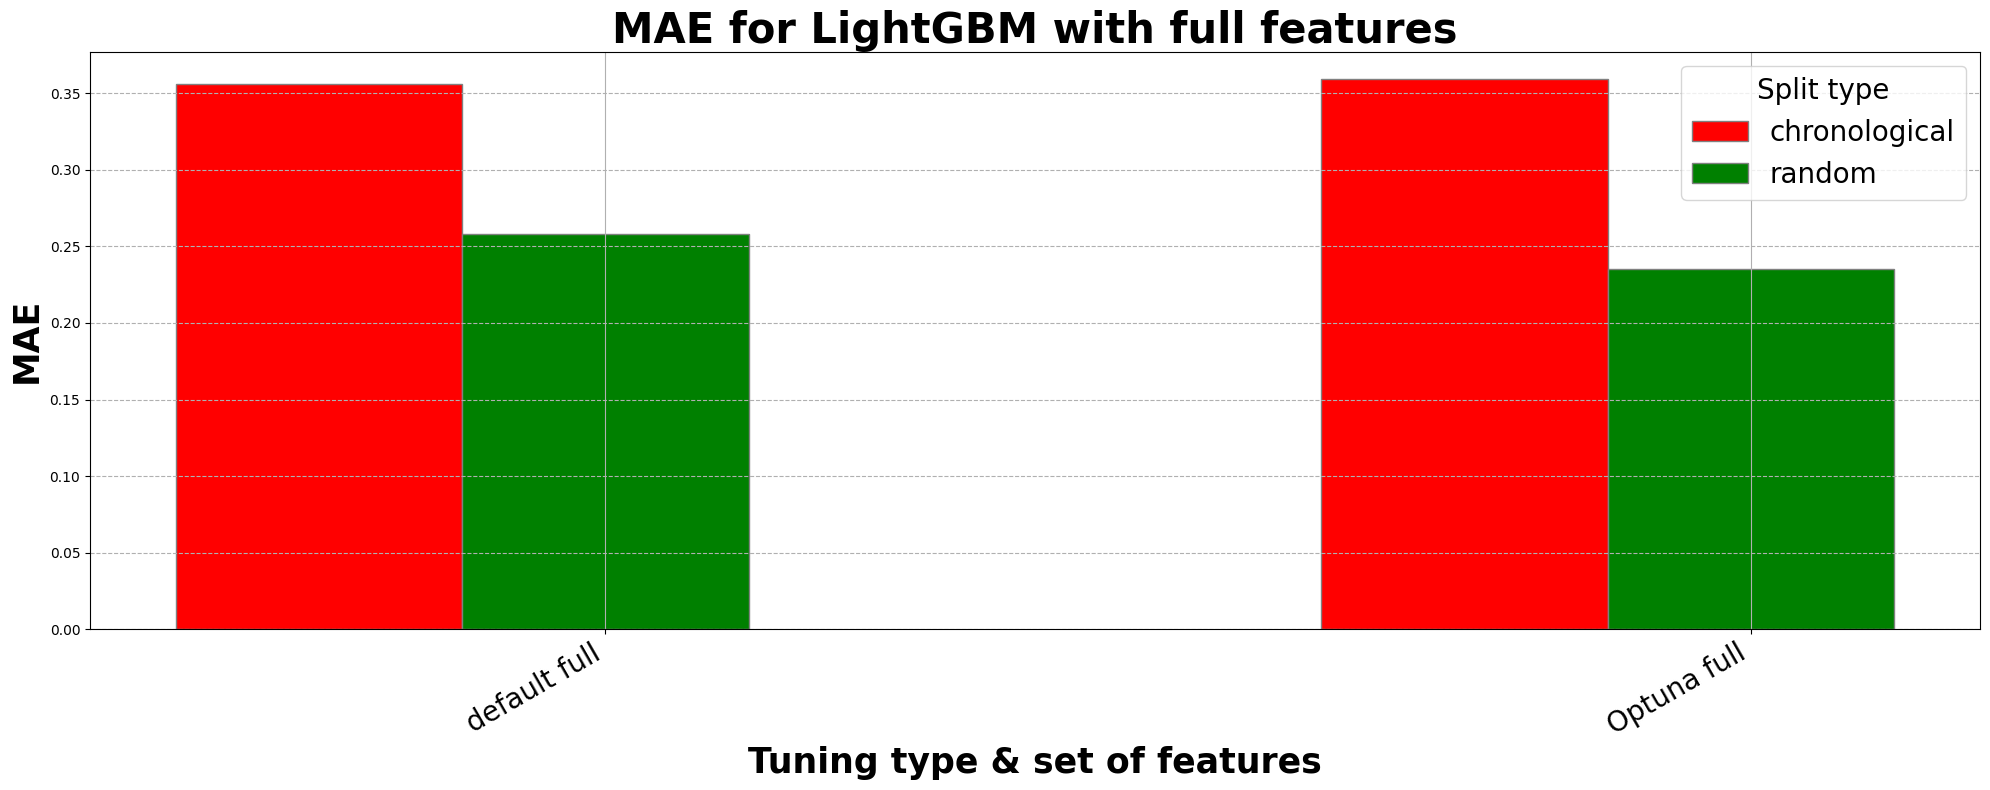

In [52]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [53]:
results.to_csv("./lightgbm_full_results.csv")